# 第5回講義 演習

## 目次

- 課題. 高度な画像認識の実装と学習
    1. CIFAR-10データセットの読み込みと可視化
    2. Data Augmentation
        - 2.1. Flipping (horizontally)
        - 2.2. Random cropping
    3. Preprocessing
        - 3.1. Global Contrast Normalization (GCN)
        - 3.2. Zero-phase Component Analysis (ZCA) Whitening
    4. Batch Normalization
    5. 畳み込みニューラルネットワーク(Convolutional Neural Networks)の実装と学習
        - 5.1. 各層クラスの実装
        - 5.2. 計-算グラフ構築 & パラメータの更新設定
        - 5.3. 学習
    6. Activationの可視化
        - 6.1. conv1
        - 6.2. conv2
        - 6.3. conv3
    7. torch.nn に含まれるlayer, Loss関数の利用
        - 7.1. ネットワークの実装
        - 7.2. 学習

## 課題. 高度な画像認識の実装と学習

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rng = np.random.RandomState(1234)
random_state = 42


## 1. CIFAR-10データセットの読み込みと可視化

In [4]:
batch_size = 1  # 可視化の際に扱いやすくするために1とする。

dataloader_train = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=False
)

Files already downloaded and verified


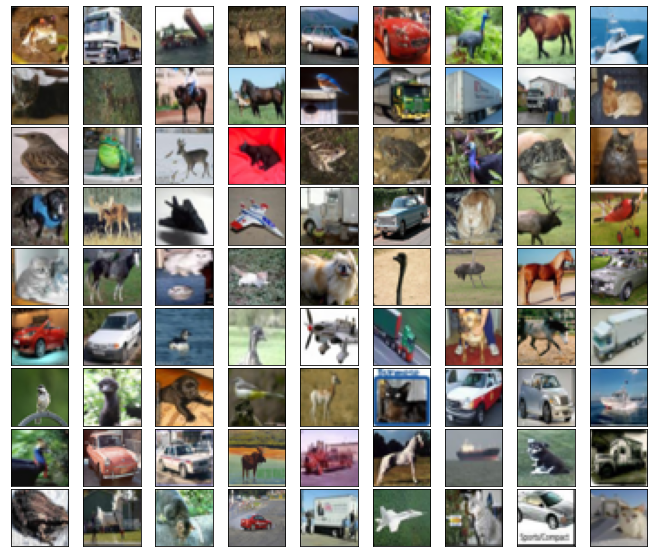

In [5]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

i = 0
for x, _ in dataloader_train:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x)
    i += 1
    if i >= 81:
        break

## 2. Data Augmentation

- Flipping (horizontally)
- Random cropping
- ...

PytorchではDataLoaderの変数transformに変換を設定することで、様々なData Augmentationを簡単に実装することができます。

### 2.1. Flipping (horizontally)

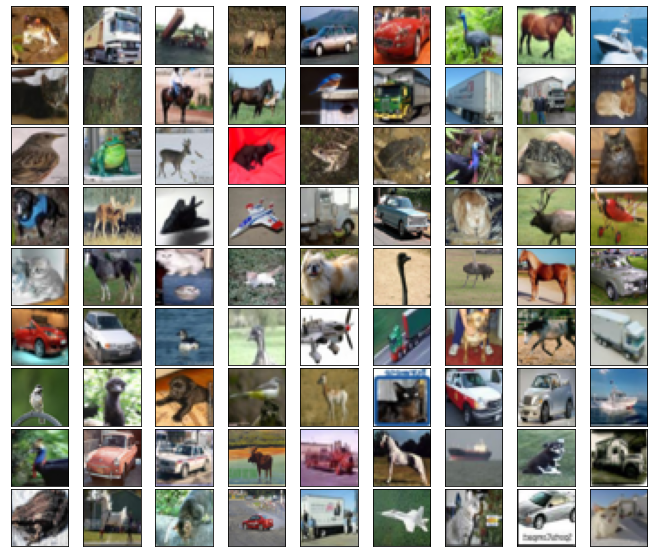

In [6]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1.0),  # horizontally flipping
                                transforms.ToTensor()])

dataloader_train_flip = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

i = 0
for x, _ in dataloader_train_flip:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x)
    i += 1
    if i >= 81:
        break

### 2.2. Random cropping

- サイズを同じにするために、拡大したあとcropping、paddingしてからcroppingなどの方法があります。
- cropは学習時に各バッチに対して行うことも多いです。
- 今回はDeep Residual Learning for Image Recognitionで使われた手法を実装します。

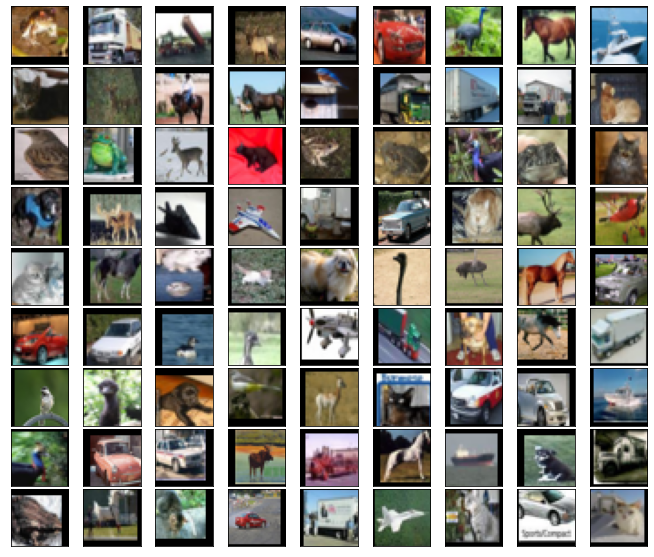

In [7]:
transform = transforms.Compose([transforms.RandomCrop(32, padding=(4, 4, 4, 4), padding_mode='constant'),  # random cropoing
                                transforms.ToTensor()])

dataloader_train_crop = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

i = 0
for x, _ in dataloader_train_crop:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x)
    i += 1
    if i >= 81:
        break

## 3. Preprocessing

- Global Contrast Normalization (GCN)
- ZCA Whitening

### 3.1. Global Contrast Normalization (GCN)

$$ {\bf x}^{norm} = \frac{{\bf x} - \bar{{\bf x}}}{\sqrt{\sigma_{{\bf x}}}} $$

- 通常の標準化とは違い，画像ごとに行います。
- 可視化した際は（可視化に際してスケールを[0,1]化しているので）見た目に変化はない。

In [9]:
# 既存のGCNクラスは存在しないので、自作する.
class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ


def deprocess(x):
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    return _x

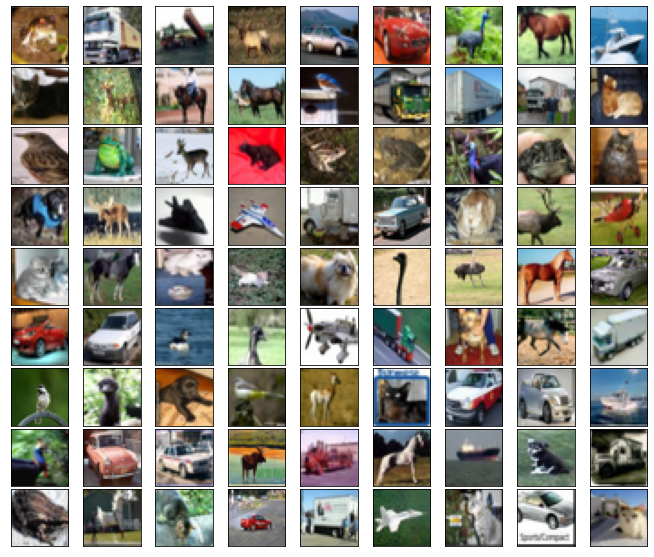

In [10]:
GCN = gcn()
transform_GCN = transforms.Compose([transforms.ToTensor(),
                                    GCN])

dataloader_train_gcn = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=True, transform=transform_GCN),
    batch_size=batch_size,
    shuffle=False
)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

i = 0
for x, _ in dataloader_train_gcn:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(deprocess(x))
    i += 1
    if i >= 81:
        break

### 3.2. Zero-phase Component Analysis (ZCA) Whitening

$$ {\bf x}^{ZCA} = A(\Lambda + \epsilon I)^{-\frac{1}{2}} A^{\mathrm{T}} ({\bf x} - \bar{\bf x}) $$

- torch.symeig(対象行列用の固有値分解)を用いてZCAを実装しています。

In [20]:
# ZCA白色化の実装
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):  # 計算が重いのでGPUを用いる
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = images[0][0].reshape(1, -1)
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        E, V = torch.symeig(con_matrix, eigenvectors=True)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())
        print("completed!")
 
    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x    

In [13]:
zca = ZCAWhitening()
images = datasets.CIFAR10('./data/cifar10', train=True, transform=transforms.ToTensor())
zca.fit(images)

0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


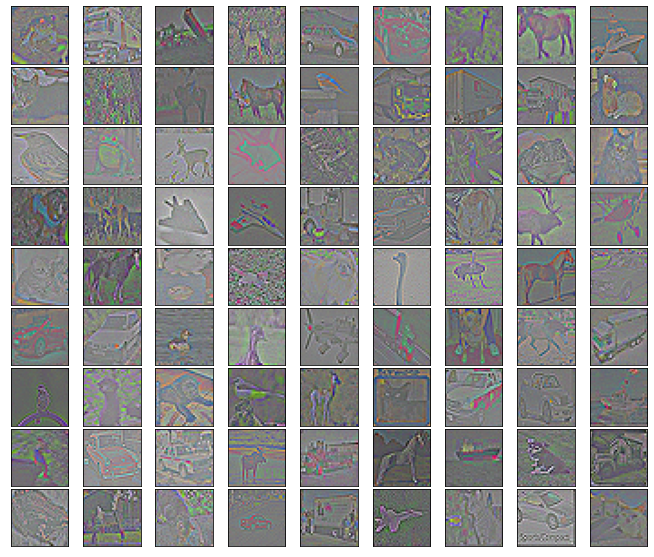

In [14]:
transform_zca = transforms.Compose([transforms.ToTensor(),
                                    zca])

dataloader_train_zca = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=True, transform=transform_zca),
    batch_size=batch_size,
    shuffle=False
)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

i = 0
for x, _ in dataloader_train_zca:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(deprocess(x))
    i += 1
    if i >= 81:
        break

## 4. Batch Normalization

![](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png?w=1008)

In [11]:
class BatchNorm(nn.Module):
    def __init__(self, shape, epsilon=np.float32(1e-5)):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(np.ones(shape, dtype='float32')))
        self.beta = nn.Parameter(torch.tensor(np.zeros(shape, dtype='float32')))
        self.epsilon = epsilon

    def forward(self, x):
        mean = torch.mean(x, (0, 2, 3), keepdim=True)
        std = torch.std(x, (0, 2, 3), keepdim=True)
        x_normalized = (x - mean) / (std**2 + self.epsilon)**0.5
        return self.gamma*x_normalized + self.beta # WRITE ME

## 5. 畳み込みニューラルネットワーク(Convolutional Neural Networks)の実装と学習

### 5.1. 各層クラスの実装

#### 畳み込み層

In [12]:
class Conv(nn.Module):
    def __init__(self, filter_shape, function=lambda x: x, stride=(1, 1), padding=0):
        super().__init__()
        # Heの初期値
        fan_in = filter_shape[1] * filter_shape[2] * filter_shape[3]
        # filter_shape: (出力チャンネル数)x(入力チャンネル数)x(縦の次元数)x(横の次元数)
        fan_out = filter_shape[0] * filter_shape[2] * filter_shape[3]
        self.W = nn.Parameter(torch.tensor(rng.uniform(
                        low= -np.sqrt(6/fan_in), # WRITE ME,
                        high= np.sqrt(6/fan_out), # WRITE ME,
                        size=filter_shape
                    ).astype('float32')))
        # バイアスはフィルタごとなので, 出力フィルタ数と同じ次元数
        self.b = nn.Parameter(torch.tensor(np.zeros((filter_shape[0]), dtype='float32')))
        self.function = function
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        u = F.conv2d(x, self.W, bias=self.b, stride=self.stride, padding=self.padding) # WRITE ME
        return self.function(u)

#### プーリング層

In [13]:
class Pooling(nn.Module):
    def __init__(self, ksize=(2, 2), stride=(2, 2), padding=0):
        super().__init__()
        self.ksize = ksize
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=self.ksize, stride=self.stride, padding=self.padding) # WRITE ME

#### 平滑化層（4次元->2次元）

In [14]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(x.size()[0], -1)

#### 全結合層

In [15]:
class Dense(nn.Module):
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        super().__init__()
        # He Initialization
        # in_dim: 入力の次元数、out_dim: 出力の次元数
        self.W = nn.Parameter(torch.tensor(rng.uniform(
                        low=-np.sqrt(6/in_dim), # WRITE ME,
                        high=np.sqrt(6/out_dim),# WRITE ME,
                        size=(in_dim, out_dim)
                    ).astype('float32')))
        self.b = nn.Parameter(torch.tensor(np.zeros([out_dim]).astype('float32')))
        self.function = function

    def forward(self, x):
        return self.function(torch.matmul(x, self.W) + self.b) # WRITE ME

#### 活性化層

In [16]:
class Activation(nn.Module):
    def __init__(self, function=lambda x: x):
        super().__init__()
        self.function = function
    
    def __call__(self, x):
        return self.function(x)

### 5.2. ネットワークの構築&データローダーの定義

In [17]:
# torch.log(0)によるnanを防ぐ
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

In [18]:
conv_net = nn.Sequential(
    Conv((32, 3, 3, 3)),     # 32x32x3 -> 30x30x32
    BatchNorm((32, 30, 30)),
    Activation(F.relu),
    Pooling((2, 2)),                  # 30x30x32 -> 15x15x32
    Conv((64, 32, 3, 3)),     # 15x15x32 -> 13x13x64
    BatchNorm((64, 13, 13)),
    Activation(F.relu),
    Pooling((2, 2)),                 # 13x13x64 -> 6x6x64
    Conv((128, 64, 3, 3)),           # 6x6x64 -> 4x4x128
    BatchNorm((128, 4, 4)),
    Activation(F.relu),
    Pooling((2, 2)),                 # 4x4x128 -> 2x2x128
    Flatten(),
    Dense(2*2*128, 256, F.relu),
    Dense(256, 10)
)

batch_size = 100
n_epochs = 5
lr = 0.01
device = 'cuda'

conv_net.to(device)
optimizer = optim.Adam(conv_net.parameters(), lr=lr)

データの読み込み

In [21]:
trainval_dataset = datasets.CIFAR10('./data/cifar10', train=True, transform=transforms.ToTensor())
#zcaを定義
zca = ZCAWhitening()
zca.fit(trainval_dataset)

# 前処理を定義
transform = transforms.Compose([transforms.ToTensor(),
                                zca])

trainval_dataset = datasets.CIFAR10('./data/cifar10', train=True, transform=transform)

# trainとvalidに分割
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [len(trainval_dataset)-10000, 10000])

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


### 5.3. 学習

In [25]:
for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    conv_net.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]

        conv_net.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動

        t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

        t = t.to(device)
        t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

        y = conv_net.forward(x) # WRITE ME  # 順伝播

        loss = -(t_hot*torch.log_softmax(y,dim=1)).sum(axis=1).mean() # WRITE ME  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward() # WRITE ME  # 誤差の逆伝播

        optimizer.step() # WRITE ME  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    conv_net.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動

        t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

        t = t.to(device)
        t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

        y = conv_net.forward(x) # WRITE ME  # 順伝播

        loss = -(t_hot*torch.log_softmax(y, dim=1)).sum(axis=1).mean() # WRITE ME  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))

EPOCH: 0, Train [Loss: 0.740, Accuracy: 0.742], Valid [Loss: 0.778, Accuracy: 0.729]
EPOCH: 1, Train [Loss: 0.609, Accuracy: 0.787], Valid [Loss: 0.755, Accuracy: 0.742]
EPOCH: 2, Train [Loss: 0.520, Accuracy: 0.816], Valid [Loss: 0.770, Accuracy: 0.743]
EPOCH: 3, Train [Loss: 0.438, Accuracy: 0.846], Valid [Loss: 0.820, Accuracy: 0.735]
EPOCH: 4, Train [Loss: 0.382, Accuracy: 0.864], Valid [Loss: 0.808, Accuracy: 0.744]


## 6. Activationの可視化

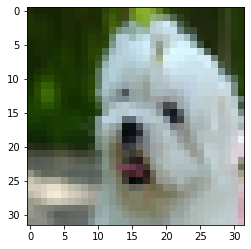

In [26]:
trainval = datasets.CIFAR10('./data/cifar10')
image_id = 919  # 表示させる画像を選択
sample_image = trainval[image_id][0]
plt.imshow(sample_image)

In [27]:
def feature_map(image, output_layer):  # output_layer番目の層の特徴マップを出力する関数
    image = transform(image)
    image = conv_net[0:output_layer + 1](image.unsqueeze(0).to(device))
    return image


print("ネットワークの構造")
print(conv_net)

ネットワークの構造
Sequential(
  (0): Conv()
  (1): BatchNorm()
  (2): Activation()
  (3): Pooling()
  (4): Conv()
  (5): BatchNorm()
  (6): Activation()
  (7): Pooling()
  (8): Conv()
  (9): BatchNorm()
  (10): Activation()
  (11): Pooling()
  (12): Flatten()
  (13): Dense()
  (14): Dense()
)


### 6.1. conv_1

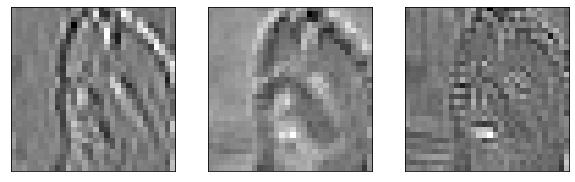

In [28]:
_output = feature_map(sample_image, 0).to("cpu")
fig = plt.figure(figsize=(10, 10))
_output = np.transpose(torch.squeeze(_output).detach().numpy(), (1, 2, 0))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, xticks=[], yticks=[])
    ax.imshow(deprocess(_output[:, :, i]), cmap='gray')

### 6.2. conv_2

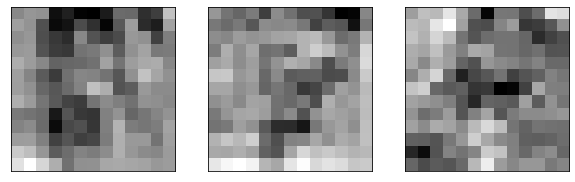

In [29]:
_output = feature_map(sample_image, 4).to("cpu")
fig = plt.figure(figsize=(10, 10))
_output = np.transpose(torch.squeeze(_output).detach().numpy(), (1, 2, 0))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, xticks=[], yticks=[])
    ax.imshow(deprocess(_output[:, :, i]), cmap='gray')

### 6.3. conv_3

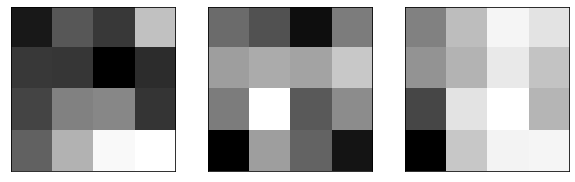

In [30]:
_output = feature_map(sample_image, 8).to("cpu")
fig = plt.figure(figsize=(10, 10))
_output = np.transpose(torch.squeeze(_output).detach().numpy(), (1, 2, 0))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, xticks=[], yticks=[])
    ax.imshow(deprocess(_output[:, :, i]), cmap='gray')

## 7. torch.nn に含まれるlayer, Loss関数の利用

これまで扱ってきたPytorchの実装では比較的低レベルなAPIを使用してきました。それは本講義ではアルゴリズムの実装にフォーカスするためです。

しかしながら、実際にビジネスや研究で利用するときにはプリミティブな実装を一から書くのは手間になる場合もあります。そのような課題を解決するニーズに答え、Pytorchには高レベルなAPIも用意されています。その一つとして`torch.nn`に含まれるlayerやLoss関数があります。

ここまでは`torch.nn.Module`クラスを継承して様々なlayerを定義してきましたが、実は`torch.nn`に主要なlayer, Loss関数は含まれています。

ここでは、`torch.nn`に含まれるlayer, Loss関数を使って、課題5の畳み込みニューラルネットワークの実装を行ってみましょう。


なお、このような高レベルなAPIは簡単に実装できる反面、実装の柔軟性が落ちるという欠点もあります。場合によって使い分ける必要があります。

`torch.nn`で使えるモジュールは以下のページで確認できます。

[Module: torch.nn](https://pytorch.org/docs/stable/nn.html)

一般的なレイヤーは一通り揃っています。

```python
# 線形層
nn.Linear(input_dim, output_dim)

# 畳み込み層
nn.Conv1d(input_dim, output_dim, kernel_size)

# LSTM
nn.LSTM(input_dim, hidden_dim, num_layers)

...
```

一般的な誤差関数も一通り揃っています。

```python
# L1誤差
nn.L1Loss()

# 平均二乗誤差
nn.MSELoss()

# 交差エントロピー誤差
nn.CrossEntropyLoss()

...
```

### 7.1. ネットワークの実装

In [31]:
conv_net2 = nn.Sequential(
    nn.Conv2d(3, 32, 3),              # 32x32x3 -> 30x30x32
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 30x30x32 -> 15x15x32
    nn.Conv2d(32, 64, 3),             # 15x15x32 -> 13x13x64
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 13x13x64 -> 6x6x64
    nn.Conv2d(64, 128, 3),            # 6x6x64 -> 4x4x128
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 4x4x128 -> 2x2x128
    nn.Flatten(),
    nn.Linear(2*2*128, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)


def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)


conv_net2.apply(init_weights)

batch_size = 100
n_epochs = 5
lr = 0.01
device = 'cuda'

conv_net2.to(device)
optimizer2 = optim.Adam(conv_net2.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()  # nn.ClossEntropyLossは、出力のsoftmax変換と、正解ラベルのone-hot vector化の機能を持っている

データの読み込み

In [32]:
trainval_dataset = datasets.CIFAR10('./data/cifar10', train=True, transform=transforms.ToTensor())

#zcaを定義
zca = ZCAWhitening()
zca.fit(trainval_dataset)

# 前処理を定義
transform = transforms.Compose([transforms.ToTensor(),
                                zca])

trainval_dataset = datasets.CIFAR10('./data/cifar10', train=True, transform=transform)

# trainとvalidに分割
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [len(trainval_dataset)-10000, 10000])

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


### 7.2. 学習

In [33]:
for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    conv_net2.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]

        conv_net2.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = conv_net2.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
      
        loss.backward()  # 誤差の逆伝播

        optimizer2.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    conv_net2.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = conv_net2.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))

EPOCH: 0, Train [Loss: 1.382, Accuracy: 0.512], Valid [Loss: 1.186, Accuracy: 0.587]
EPOCH: 1, Train [Loss: 0.871, Accuracy: 0.693], Valid [Loss: 0.995, Accuracy: 0.659]
EPOCH: 2, Train [Loss: 0.697, Accuracy: 0.756], Valid [Loss: 0.827, Accuracy: 0.718]
EPOCH: 3, Train [Loss: 0.600, Accuracy: 0.793], Valid [Loss: 0.745, Accuracy: 0.751]
EPOCH: 4, Train [Loss: 0.526, Accuracy: 0.819], Valid [Loss: 0.759, Accuracy: 0.746]
